In [1]:
import torch
import segmentation_models_pytorch as smp
import pandas as pd
from inference import extract_dataframe_from_split
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import shap

In [ ]:
# Gather the required dataframes to train the gradient boosting model

DATA_DIR = r"./data/meta_model" # Path to your data
MODEL_DIR = r"./Save/97.72.pt" # Path to your model checkpoint
SCALES = [512, 1024, 2048]
TARGET_RES = 1024
NUM_SAMPLES_PER_IMAGE = 50000  # Adjust based on image size or dynamically

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(MODEL_DIR, map_location=device)
model = smp.UnetPlusPlus(encoder_name='timm-efficientnet-b8', encoder_weights="advprop", in_channels=3, classes=1, activation='sigmoid')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

df_train = extract_dataframe_from_split(DATA_DIR, TARGET_RES, SCALES, NUM_SAMPLES_PER_IMAGE, "train", model, device, 7)
df_val = extract_dataframe_from_split(DATA_DIR, TARGET_RES, SCALES, NUM_SAMPLES_PER_IMAGE, "val", model, device, 7)
df_test = extract_dataframe_from_split(DATA_DIR, TARGET_RES, SCALES, NUM_SAMPLES_PER_IMAGE, "test", model, device, 7)

df_train.to_csv("meta_train.csv", index=False)
df_val.to_csv("meta_val.csv", index=False)
df_test.to_csv("meta_test.csv", index=False)

In [2]:
# Train the LightGBM model using the extracted features and labels

def iou_metric_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred_label = (y_pred > 0.5).astype(int)
    
    intersection = np.logical_and(y_true, y_pred_label).sum()
    union = np.logical_or(y_true, y_pred_label).sum()
    iou = intersection / union if union != 0 else 1.0
    return 'iou', iou, True

df_train, df_val, df_test = pd.read_csv("meta_train.csv"), pd.read_csv("meta_val.csv"), pd.read_csv("meta_test.csv")
features = ['p_sky_512', 'p_sky_1024', 'p_sky_2048',
        'r', 'g', 'b',
        'h', 'v',
        'patch_mean', 'patch_std',
        'uniformity', 'entropy', 'texture',
        'FD_RGB', 'FD_HSV',
        'excess_blue', 'gray_contrast'
        ]
target = 'label'
dtrain = lgb.Dataset(df_train[features], label=df_train[target])
dval = lgb.Dataset(df_val[features], label=df_val[target], reference=dtrain)

#You can optimize your own parameters using Optuna or any other hyperparameter optimization library.
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.11960145308607649,
    'num_leaves': 42,
    'lambda_l1': 1.070747942241319,
    'lambda_l2': 9.87665458579294,
    'feature_fraction': 0.5624075052818188,
    'bagging_fraction': 0.6908676856831678,
    'min_child_samples': 53,
    'max_depth': 8,
    'verbose': -1
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    feval=iou_metric_lgb,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

y_pred_proba = model.predict(df_test[features])
y_pred = (y_pred_proba > 0.5).astype(int) #binarize to compute jaccard score

print(f'IOU: {jaccard_score(df_test[target], y_pred)}')

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0443354	valid_0's iou: 0.975359
[100]	valid_0's binary_logloss: 0.043576	valid_0's iou: 0.975452
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0434966	valid_0's iou: 0.975495
IOU: 0.9667634435077738


In [3]:
# Save the model for future use

model.save_model('meta_model.txt')

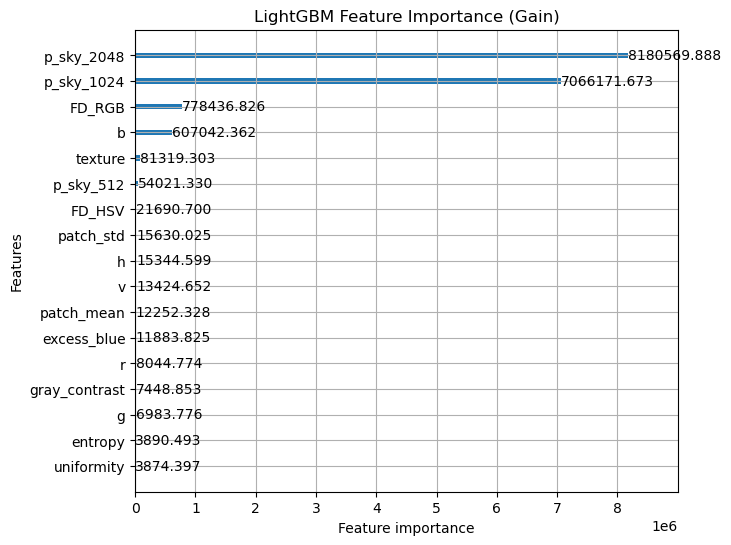

In [4]:
# Plot feature importance using LightGBM's built-in function

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

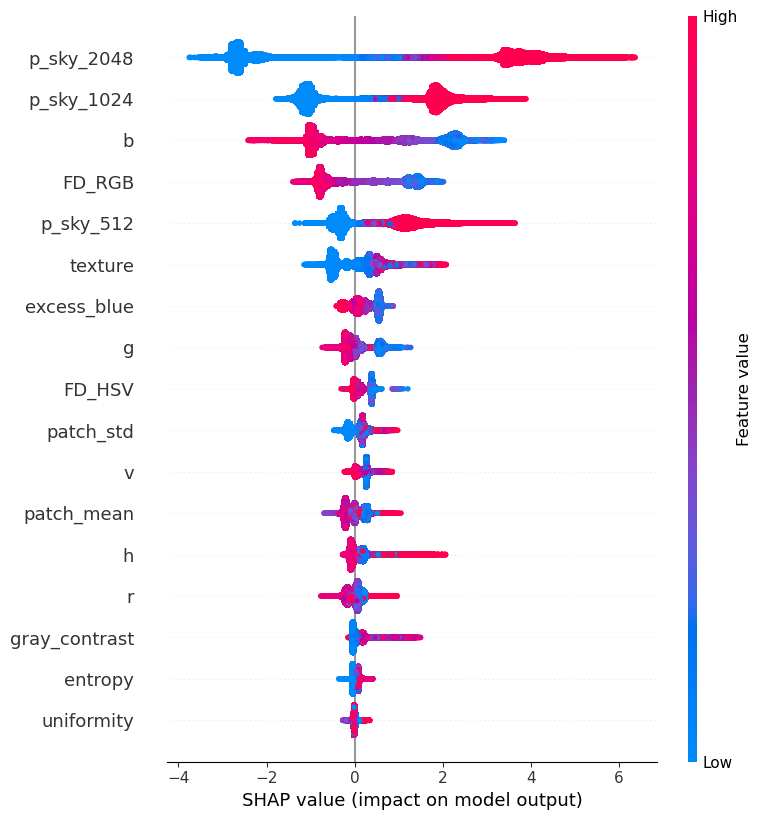

In [5]:
# Use SHAP to explain the model predictions

explainer = shap.Explainer(model)
shap_values = explainer(df_test[features])
shap.summary_plot(shap_values, df_test[features])

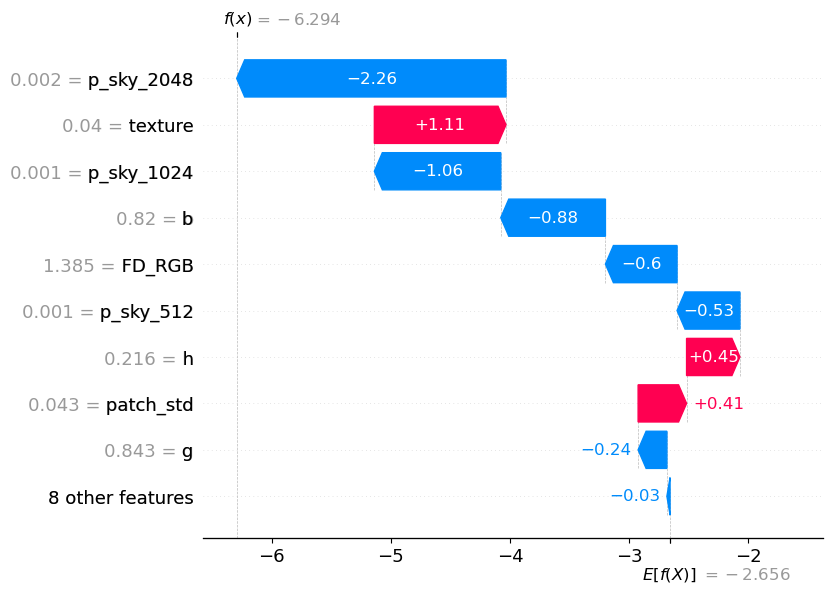

In [ ]:
# Waterfall plot for a single prediction

shap.plots.waterfall(shap_values[1]) #change to the index of the instance you want to visualize

In [ ]:
# You can find the model output using the sigmoid function on f(x)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid(-6.294) # f(x) = -6.294, example output

0.0018439492950957075

In [ ]:
# Optional: Optimize hyperparameters using Optuna

import optuna

df_train, df_val, df_test = pd.read_csv("meta_train.csv"), pd.read_csv("meta_val.csv"), pd.read_csv("meta_test.csv")
features = ['p_sky_512', 'p_sky_1024', 'p_sky_2048',
        'r', 'g', 'b',
        'h', 'v',
        'patch_mean', 'patch_std',
        'uniformity', 'entropy', 'texture',
        'FD_RGB', 'FD_HSV',
        'excess_blue', 'gray_contrast'
        ]
target = 'label'
dtrain = lgb.Dataset(df_train[features], label=df_train[target])
dval = lgb.Dataset(df_val[features], label=df_val[target], reference=dtrain)

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'num_leaves': trial.suggest_int('num_leaves', 16, 63),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'feature_pre_filter': False,
        'verbose': -1
    }

    gbm = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
        feval=iou_metric_lgb,
        callbacks=[
            lgb.early_stopping(30, verbose=False)
        ]
    )

    y_pred = (gbm.predict(df_val[features]) > 0.5).astype(int)
    return jaccard_score(df_val[target], y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, gc_after_trial=True)
print("Best hyperparameters:", study.best_params)
print("Best IoU:", study.best_value)